In [1]:
import numpy as np
import glob
import os
import importlib
import yaml
import albumentations
import glob
import json
import torch
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from PIL import Image
from torch.utils.data import random_split, DataLoader, Dataset
from omegaconf import OmegaConf
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

def imshow(images, titles=None):
    n_img = len(images)
    plt.rcParams['figure.figsize'] = [8*n_img, 8*n_img]
    
    if n_img > 1:
        fig, ax = plt.subplots(1, n_img)
        for i in range(n_img):
            if titles is not None and i < len(titles):
                ax[i].set_title(titles[i])
            ax[i].axis('off')
            ax[i].imshow(images[i])
    else:
        if titles is not None:
            plt.set_titile(titles[0])
        plt.axis('off')
        plt.imshow(images[0])

def center_crop(image, s=512):
    h, w = image.shape[:2]
    assert s <= h and s <= w
    ih = (h - s) // 2
    iw = (w - s) // 2
    return image[ih:ih+s, iw:iw+s]

# load a single input
def preprocess(x, res=512, normalize=True):
    if normalize:
        x = x.transpose(2,0,1)
        x = (torch.from_numpy(x).float().to(device) / 127.5 - 1).unsqueeze(0)
    else:
        x = torch.from_numpy(x).float().to(device).unsqueeze(0)
    return torch.nn.functional.interpolate(x, size=(res,res))
    
def to_img(x):
    x = (x.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
    return x[0].detach().cpu().numpy()

def readmask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    return mask

# validation input
places_val_files = glob.glob("/home/ICT2000/chenh/Haiwei/Datasets/Places365/val_large/*.jpg")

# images = [center_crop(imread(f)) for f in places_val_files[k:k+3]]
# imshow(images)

# validation results (MAT)
places_val_files.sort()
image_names = [os.path.basename(p).replace('jpg', 'png') for p in places_val_files]
MAT_rstfolder = "/home/ICT2000/chenh/Haiwei/MAT/pr6_places_final"

# preds = [imread(os.path.join(MAT_rstfolder, n)) for n in image_names]
# imshow(preds)

# mask folder
maskfolder = "/home/ICT2000/chenh/Haiwei/Datasets/Places365/masks_val_512_eval"
ids = [im[-10:-4] for im in image_names]

# masks = [readmask(os.path.join(maskfolder, f"{id}.png")) for id in ids]
# imshow(masks)

def get_data(k, res):
    gt = preprocess(center_crop(imread(places_val_files[k])), res)
    mask_in = preprocess(readmask(os.path.join(maskfolder, f"{ids[k]}.png"))[None], res,normalize=False)
    return gt, mask_in

current_dir = os.path.abspath('.')
current_dir


'/home/ICT2000/chenh/Haiwei/taming-transformers'

In [30]:
# Loading MAT network models
MAT_folder = "/home/ICT2000/chenh/Haiwei/MAT/MAT"
os.chdir(MAT_folder)
from networks.mat import Generator
import dnnlib
import legacy

ckpt_path = "models/Places_512.pkl" # Places_512_FullData.pkl
device = torch.device('cuda:1')
with dnnlib.util.open_url(ckpt_path) as f:
    G_saved = legacy.load_network_pkl(f)['G_ema'].to(device).eval().requires_grad_(False) # type: ignore

def named_params_and_buffers(module):
    assert isinstance(module, torch.nn.Module)
    return list(module.named_parameters()) + list(module.named_buffers())


def copy_params_and_buffers(src_module, dst_module, require_all=False):
    assert isinstance(src_module, torch.nn.Module)
    assert isinstance(dst_module, torch.nn.Module)
    src_tensors = {name: tensor for name, tensor in named_params_and_buffers(src_module)}
    for name, tensor in named_params_and_buffers(dst_module):
        assert (name in src_tensors) or (not require_all)
        if name in src_tensors:
            tensor.copy_(src_tensors[name].detach()).requires_grad_(tensor.requires_grad)

net_res = 512
G = Generator(z_dim=512, c_dim=0, w_dim=512, img_resolution=net_res, img_channels=3).to(device).eval().requires_grad_(False)
copy_params_and_buffers(G_saved, G, require_all=True)
    

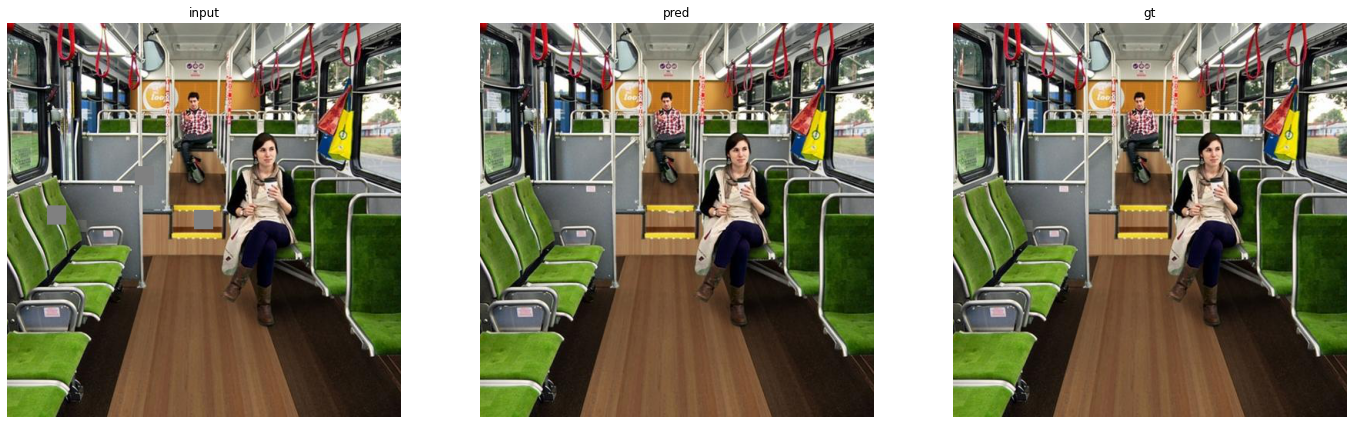

In [35]:
# Evaluation with the MAT pretrained model
with torch.no_grad():
    k = 4094
    res = 512
    gt = preprocess(center_crop(imread(places_val_files[k])), res)
    x = gt
    mask_in = preprocess(readmask(os.path.join(maskfolder, f"{ids[k]}.png"))[None], res,normalize=False)

    #############################
    mask = box_mask(x.shape, x.device, 0.05, det=True).float()
    for i in range(2):
        bmask = box_mask(x.shape, x.device, 0.05, det=False).float()
        mask = torch.logical_and(mask, bmask).float()
    mask_in = torch.round(mask).to(device)
    ##################################
    
    pred_ref = preprocess(imread(os.path.join(MAT_rstfolder, image_names[k])), res)
    x_in = gt * mask_in

    # inference with MAT network models

    # no Labels.
    label = torch.zeros([1, G.c_dim], device=device)
    z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
    output = G(x_in, mask_in, z, label, truncation_psi=1, noise_mode='const')
    output = (output.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
    output_mat = output[0].detach().cpu().numpy()

imshow([to_img(x_in), output_mat, to_img(gt)], titles=['input','pred', 'gt'])

In [2]:
# loading our model
os.chdir(current_dir)

from omegaconf import OmegaConf
import yaml
import torch.nn.functional as F
import importlib
from torch.utils.data import random_split, DataLoader, Dataset

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

device = torch.device('cuda:1')
config_path = "configs/places_inpainting.yaml"
config = OmegaConf.load(config_path)
config['data']['params']['batch_size'] = 1

config['model']['params']['encoder_config']['params']['ddconfig']['clamp_ratio'] = 0.25

model = instantiate_from_config(config.model).to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/places256_vqgan1024_BASE/checkpoints/last.ckpt
Restored from logs/2023-05-26T15-25-34_places256_partialencoder_1024_cont/checkpoints/last.ckpt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from logs/2023-05-16T18-06-38_randommask_decoder_preceptual/checkpoints/last.ckpt
Restored from logs/2023-06-30T12-34-38_places_maskgit_1024/checkpoints/last.ckpt
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.


In [ ]:
# optional: using dataloader 
data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()
dataset = data.datasets['test']
batch = dataset[0]
batch['mask'].shape

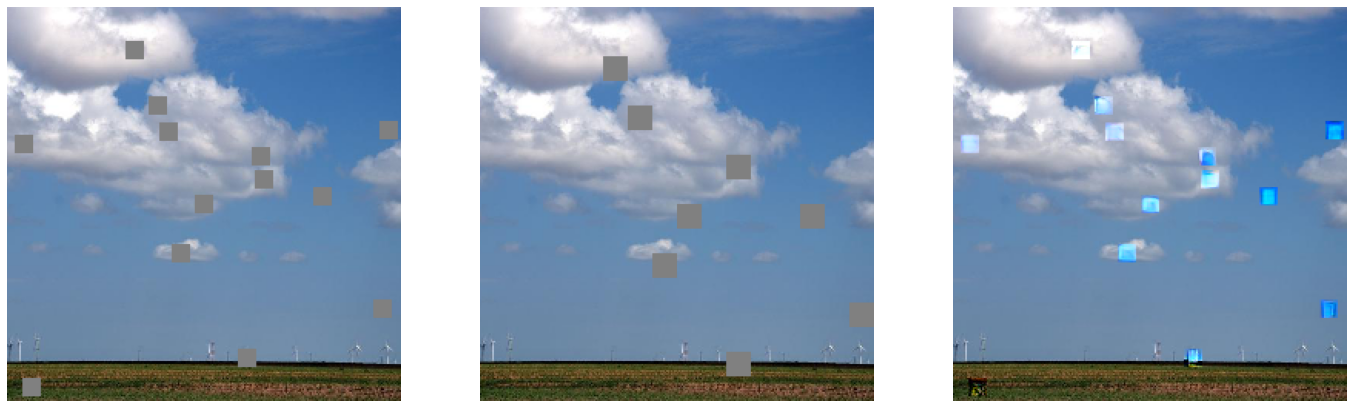

In [29]:
from taming.modules.util import scatter_mask, box_mask, mixed_mask, BatchRandomMask

# 4843 (dec), 2421 (dec), 717 (git), 2376 (git), 37 (dec)

# batch = dataset[0]
# print(batch['filename_'])


with torch.no_grad():
    # gt = torch.from_numpy(batch['image'].transpose(2,0,1)).unsqueeze(0).to(device)
    # mask = torch.from_numpy(batch['mask'].transpose(2,0,1)).unsqueeze(0).to(device)
    gt, mask = get_data(37, 256)
    x = gt.to(device)
    
    #############################
    mask = box_mask(x.shape, x.device, 0.05, det=True).float()
    for i in range(12):
        bmask = box_mask(x.shape, x.device, 0.05, det=False).float()
        mask = torch.logical_and(mask, bmask).float()
    ##################################
    mask = torch.round(mask).to(device)
    
    VQModel, Encoder, Transformer = model.helper_model
    VQModel = VQModel.to(device)
    Encoder = Encoder.to(device)
    Transformer = Transformer.to(device)

    gt_quant_z, _, _ = VQModel.encode(x)
    
    quant_z, _, info, mask_out = Encoder.encode(x*mask, mask)
    mask_out = mask_out.reshape(x.shape[0], -1)
    z_indices = info[2].reshape(x.shape[0], -1)
    batch = {'image': x.permute(0,2,3,1)}
    z_indices_complete = Transformer.forward_to_indices(batch, z_indices, mask_out, temperature=0.5, det=False)
    B, C, H, W = quant_z.shape

    quant_z_complete = VQModel.quantize.get_codebook_entry(z_indices_complete.reshape(-1).int(), shape=(B, H, W, C))


    mask_out_interpolate = F.interpolate(mask, (16,16)).reshape(x.shape[0], -1)
    
    # rec, _, _, quant_z, _, _ = model(batch, recomposition=True, mask=mask, simple_return=False)
    # rec_fstg = VQModel.decode(quant_z)

    rec_fstg = VQModel.decode(quant_z_complete)
    
    dec, _ = model.current_model(batch, 
                                quant=quant_z_complete, 
                                mask_in=mask, 
                                mask_out=mask_out.reshape(B, 1, H, W),
                                return_fstg=False)
    rec = x * mask + dec * (1-mask) 
    

mask_int = F.interpolate(F.interpolate(mask, size=(16,16), mode='nearest'),(256,256))
mask_out_int = F.interpolate(mask_out.reshape(1,1,16,16),(256,256))

imshow([to_img(x*mask),to_img(x*mask_int), to_img(rec)])

In [ ]:
# imshow([to_img(x*mask),to_img(x*mask_out), to_img(rec_fstg), to_img(rec)])
print(np.unique(mask_int.detach().cpu().numpy()))
imshow([to_img(x*mask), to_img(x*mask_out_int), to_img(x*(mask_int>0.25))])


In [ ]:
with torch.no_grad():
    gt_quant_z, _, _ = VQModel.encode(x)
    m = mask_out.reshape(1,1,16,16)
    quant_compose = (1-m) * gt_quant_z + m * quant_z
    rec_gt = VQModel.decode(gt_quant_z)
    rec_cls = VQModel.decode(quant_compose)

imshow([to_img(rec_gt), to_img(rec_cls)])

In [ ]:
@torch.no_grad()
def predict(gt, mask, m):
    x = gt.to(device)
    mask_in = mask.to(device)
    batch = {'image': gt.permute(0,2,3,1)}
    rec, _ = m(batch, recomposition=False, mask=mask_in, simple_return=True)

    # linear blending
    k = 3
    kernel = torch.ones(1,1,k,k) / k**2
    pad = k // 2
    smoothed_mask = F.conv2d(F.pad(mask_in,(pad,pad,pad,pad),value=1), kernel.to(mask_in.device), bias=None, padding=0)
    smoothed_mask = mask_in
    
    # composition
    rec = smoothed_mask * gt + (1 - smoothed_mask) * rec
    return rec




gt, mask = get_data(4, 256)
rst = predict(gt, mask, model)
imshow([to_img(gt*mask), to_img(rst)], titles=['input','pred'])